# 4. Use Case on Comparing Networks

Authors: **Gorka Zamora-López** and **Matthieu Gilson**

---------------------

This notebook is part of an introductory tutorial for the use of *Stimulus-Response Network Analysis* ([SiReNetA](https://github.com/mb-BCA/SiReNetA)) to study the structure of complex networks:
1. *[Getting Started and Overview](1_GettingStarted.ipynb)*
2. *[Calculating Response to Stimulus and Metrics](2_Basics_StimRespMetrics.ipynb)*
3. *[Canonical Models](3_Basics_CanonModels.ipynb)*
4. **[Comparing Networks](4_UseCase_CompareNets.ipynb)**
5. *[Network Distance](5_UseCase_NetDist.ipynb)*
6. *[Weighted Networks](6_Basics_WeightedNets.ipynb)* 

---------------------

### Outline of use case
* Reproduce Fig 3 of [Zamora-López and Gilson (2024) Chaos](https://doi.org/10.1063/5.0202241)
* Show the equivalence between graph distance for discrete cascade and time-to-peak distance for leaky cascade for several binary graphs.
* 

---------------------

## Import libraries

In [1]:
try:
    import galib
except ImportError:
    %pip install git+https://github.com/gorkazl/pyGAlib.git@master    

In [2]:
# Python standard library imports
from timeit import default_timer as timer

# Third party imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg

import sireneta as sna
import galib
import galib.metrics_numba 

# Import local libraries


<br>

## 1. Properties of the original graphs (before normalization)

Write me here. Short introduction.


Begin by choosing the type of network to generate between three graph models:
- **Random**: Random graph of $G(N,L)$ class, with prespecified number of links.
- **Lattice**: A 1-dimensional ring lattice.
- **ScaleFree**: Random graph with scale-free-like degree distribution. For the small sizes here employed (N ≤ 500 nodes) the resulting degree distribution will be skewed but not fully scale-free.

In [144]:
# Define the colors for plots later
#cols = ['deepskyblue', '#1f77b4', 'red', '#d62728']
cols = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Define the default scale for the plots
plt.rcParams['figure.dpi'] = 72

# Define a new "BwR" colormap 
from matplotlib.colors import ListedColormap
newcmap = genfromtxt('../Data/Matplotlib_colormap_div.csv', delimiter=',')
divmap = ListedColormap(newcmap)
seqhot = ListedColormap(newcmap[128:, :])
seqcool = ListedColormap(newcmap[:128, :])

In [4]:
# Define basic parameters for the graphs
N1 = 200
N2 = 500
dens1 = 0.06
dens2 = 0.1
L1s = int(round( 0.5*dens1*N1*(N1-1) ))
L1d = int(round( 0.5*dens2*N1*(N1-1) ))
L2s = int(round( 0.5*dens1*N2*(N2-1) ))
L2d = int(round( 0.5*dens2*N2*(N2-1) ))
z1s = 6; z1d = 10
z2s = 15; z2d = 25

# Create three networks, of different class and different sizes / densities
net1 = galib.models.RandomGraph(N1, L1s).astype(float64)
net2 = galib.models.Lattice1D(N1, z1d).astype(float64)
net3 = galib.models.ScaleFreeGraph(N2, L2s).astype(float64)

# Make sure the networks are connected
indeg1 = net1.sum(axis=0);  outdeg1 = net1.sum(axis=1)
indeg2 = net2.sum(axis=0);  outdeg2 = net2.sum(axis=1)
indeg3 = net3.sum(axis=0);  outdeg3 = net3.sum(axis=1)
assert 0 not in [indeg1.min(), indeg2.min(), indeg3.min()], 'Disconnected graph found'


In [5]:
def SpectralRadius(eigenvalues):
    """Finds the eigenvalue with largest norm in the imaginary space."""
    
    N = len(eigenvalues)
    evnorms = np.zeros(N, float64)
    for i in range(N):
        evnorms[i] = numpy.linalg.norm(eigenvalues[i])
    maxradius = evnorms.max()

    return maxradius

In [40]:
# Compute the eigenvalues of the four networks
evs1 = numpy.linalg.eigvals(net1)
evs2 = numpy.linalg.eigvals(net2)
evs3 = numpy.linalg.eigvals(net3)

# Find the largest eigenvalues, and the corresponding critical τ for each network
evmax1 = SpectralRadius(evs1); taumax1 = 1.0 / evmax1
evmax2 = SpectralRadius(evs2); taumax2 = 1.0 / evmax2
evmax3 = SpectralRadius(evs3); taumax3 = 1.0 / evmax3

# Normalize the networks
nnet1 = net1 / evmax1
nnet2 = net2 / evmax2
nnet3 = net3 / evmax3

# Compute the eigenvalues of the normalised networks
nevs1 = numpy.linalg.eigvals(nnet1)
nevs2 = numpy.linalg.eigvals(nnet2)
nevs3 = numpy.linalg.eigvals(nnet3)

# Find the largest eigenvalues, and the new critical τ for each network
nevmax1 = SpectralRadius(nevs1); ntaumax1 = 1.0 / nevmax1
nevmax2 = SpectralRadius(nevs2); ntaumax2 = 1.0 / nevmax2
nevmax3 = SpectralRadius(nevs3); ntaumax3 = 1.0 / nevmax3


In [41]:
# Print some feedback: spectral radius and corresponding critical 'tau's
print( 'BEFORE NORMALIZATION ...')
print( '\t\tSpectral radius\t\tLargest tau' )
print( 'net #1 (rand):  %3.5f\t\t%2.5f'  %(evmax1, taumax1) )
print( 'net #2 (latt):  %3.5f\t\t%2.5f'  %(evmax2, taumax2) )
print( 'net #3 (scfr):  %3.5f\t\t%2.5f'  %(evmax3, taumax3) )

# Print some feedback: spectral radius and corresponding critical 'tau's
print( '\nAFTER NORMALIZATION ...')
print( '\t\tSpectral radius\t\tLargest tau' )
print( 'net #1 (rand):   %3.5f\t\t%2.5f'  %(nevmax1, ntaumax1) )
print( 'net #2 (latt):   %3.5f\t\t%2.5f'  %(nevmax2, ntaumax2) )
print( 'net #3 (scfr):   %3.5f\t\t%2.5f'  %(nevmax3, ntaumax3) )

BEFORE NORMALIZATION ...
		Spectral radius		Largest tau
net #1 (rand):  12.89676		0.07754
net #2 (latt):  20.00000		0.05000
net #3 (scfr):  44.70711		0.02237

AFTER NORMALIZATION ...
		Spectral radius		Largest tau
net #1 (rand):   1.00000		1.00000
net #2 (latt):   1.00000		1.00000
net #3 (scfr):   1.00000		1.00000


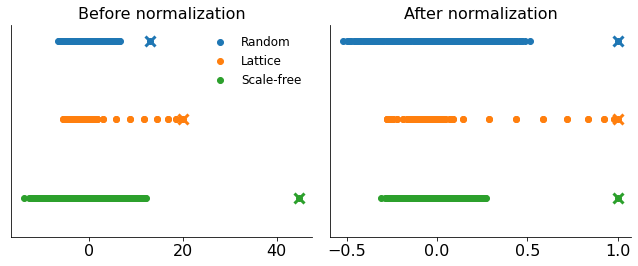

In [56]:
# Plot the eigenvalues for comparison
plt.figure(figsize=(9,3.8))

# BEFORE normalization
ax1 = plt.subplot(1,2,1)
ax1.spines[['top','right']].set_visible(False)
ax1.get_yaxis().set_visible(False)
plt.title( 'Before normalization', fontsize=16 )

plt.scatter(evs1.real, 0.03 + evs1.imag, c=cols[0], label='Random')
plt.scatter(evs2.real, 0.02 + evs2.imag, c=cols[1], label='Lattice')
plt.scatter(evs3.real, 0.01 + evs3.imag, c=cols[2], label='Scale-free')

plt.scatter(evmax1, 0.03, marker='x', s=100, lw=3, c=cols[0])
plt.scatter(evmax2, 0.02, marker='x', s=100, lw=3, c=cols[1])
plt.scatter(evmax3, 0.01, marker='x', s=100, lw=3, c=cols[2])

plt.ylim(0.005,0.032)
plt.tick_params( labelsize=16 )

plt.legend(frameon=False, loc='upper right', fontsize=12)


# AFTER normalization
ax2 = plt.subplot(1,2,2)
ax2.spines[['top','right']].set_visible(False)
ax2.get_yaxis().set_visible(False)
plt.title( 'After normalization', fontsize=16 )

plt.scatter(nevs1.real, 0.03 + nevs1.imag, c=cols[0], label='Random')
plt.scatter(nevs2.real, 0.02 + nevs2.imag, c=cols[1], label='Lattice')
plt.scatter(nevs3.real, 0.01 + nevs3.imag, c=cols[2], label='Scale-free')

plt.scatter(nevmax1, 0.03, marker='x', s=100, lw=3, c=cols[0])
plt.scatter(nevmax2, 0.02, marker='x', s=100, lw=3, c=cols[1])
plt.scatter(nevmax3, 0.01, marker='x', s=100, lw=3, c=cols[2])

plt.ylim(0.005,0.032)
plt.tick_params( labelsize=16 )

plt.tight_layout()


In [43]:
# 1) COMPUTE THE DYNAMIC COMMUNICABILITY AND CALCULATE SOME PROPERTIES
# 1.1) Define the simulation parameters
# Define the temporal resolution
tfinal = 0.6
dt = 0.005
tpoints = arange(0.0, tfinal+0.1*dt, dt)
nsteps = len(tpoints)

# Set the decay time-constants τ, proportional to taumax
tauratio = 0.8
tau1 = tauratio * taumax1
tau2 = tauratio * taumax2
tau3 = tauratio * taumax3

# Define the inputs to every node
stim = 1.0

# 1.3) Calculate the evolution of communicability over time for the nets
print('\nCalculating the dynamic communicability tensors from t=0 to t=%3.1f, with step=%3.3f ...' %(tfinal, dt) )
time1 = timer()
netresp1 = sna.Resp_LC(net1.T, tau=tau1, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
netresp2 = sna.Resp_LC(net2.T, tau=tau2, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
netresp3 = sna.Resp_LC(net3.T, tau=tau3, S0=stim, tmax=tfinal, timestep=dt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )

# 1.4) Compute the global network responses
# Sum of all pair-wise responses, at every time-point
globalresp1 = sna.GlobalResponse(netresp1)
globalresp2 = sna.GlobalResponse(netresp2)
globalresp3 = sna.GlobalResponse(netresp3)



Calculating the dynamic communicability tensors from t=0 to t=0.6, with step=0.005 ...
6.138177856999846 seconds


In [44]:
# COMPUTE THE DYNAMIC COMMUNICABILITY AND CALCULATE SOME PROPERTIES
# 1.1) Define the simulation parameters
# Define the temporal resolution
ntfinal = 12.0
ndt = 0.05
ntpoints = arange(0.0, ntfinal+0.1*ndt, ndt)
#nnsteps = len(ntpoints)

# Set the decay time-constants τ, proportional to taumax
# After normalization all taumax = 1.0, hence, we only need one value for
# all four networks.
ntau = 0.8

# Define the inputs to every node
stim = 1.0

# Calculate the evolution of communicability over time for the nets
print('\nCalculating the dynamic communicability tensors from t=0 to t=%3.1f, with step=%3.3f ...' %(ntfinal, ndt) )
time1 = timer()
nnetresp1 = sna.Resp_LC(nnet1.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nnetresp2 = sna.Resp_LC(nnet2.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nnetresp3 = sna.Resp_LC(nnet3.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )

# 1.4) Compute the global network responses
# Sum of all pair-wise responses, at every time-point
nglobalresp1 = sna.GlobalResponse(nnetresp1)
nglobalresp2 = sna.GlobalResponse(nnetresp2)
nglobalresp3 = sna.GlobalResponse(nnetresp3)



Calculating the dynamic communicability tensors from t=0 to t=12.0, with step=0.050 ...
11.359228779000205 seconds


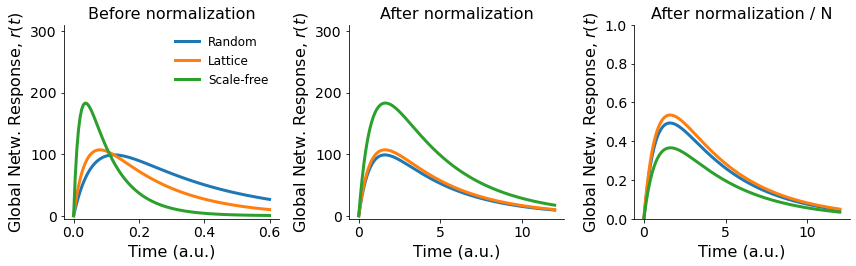

In [110]:
# Plot the global network responses
plt.figure(figsize=(12,3.8))

# BEFORE normalization
ax1 = plt.subplot(1,3,1)
ax1.spines[['top','right']].set_visible(False)
plt.title( 'Before normalization', fontsize=16 )

plt.plot(tpoints, globalresp1, lw=3, c=cols[0], label='Random')
plt.plot(tpoints, globalresp2, lw=3, c=cols[1], label='Lattice')
plt.plot(tpoints, globalresp3, lw=3, c=cols[2], label='Scale-free')

plt.ylim(-5,310)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel('Global Netw. Response, $r(t)$', fontsize=16)

plt.legend(frameon=False, fontsize=12)


# AFTER normalization
ax2 = plt.subplot(1,3,2)
ax2.spines[['top','right']].set_visible(False)
plt.title( 'After normalization', fontsize=16 )

plt.plot(ntpoints, nglobalresp1, lw=3, c=cols[0], label='Random')
plt.plot(ntpoints, nglobalresp2, lw=3, c=cols[1], label='Lattice')
plt.plot(ntpoints, nglobalresp3, lw=3, c=cols[2], label='Scale-free')

plt.ylim(-5,310)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel('Global Netw. Response, $r(t)$', fontsize=16)
#plt.legend(frameon=False, fontsize=12)


# AFTER normalization
ax3 = plt.subplot(1,3,3)
ax3.spines[['top','right']].set_visible(False)
plt.title( 'After normalization / N', fontsize=16 )

plt.plot(ntpoints, nglobalresp1 / N1, lw=3, c=cols[0], label='Random')
plt.plot(ntpoints, nglobalresp2 / N1, lw=3, c=cols[1], label='Lattice')
plt.plot(ntpoints, nglobalresp3 / N2, lw=3, c=cols[2], label='Scale-free')

plt.ylim(0,1)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel('Global Netw. Response, $r(t)$', fontsize=16)
#plt.legend(frameon=False, fontsize=12)


plt.tight_layout()


Write some brief explanations here …

In [57]:
# 1.4) Compare the (input) degrees to the node responses
noderesp1 = sna.NodeResponses(netresp1)[0]
noderesp2 = sna.NodeResponses(netresp2)[0]
noderesp3 = sna.NodeResponses(netresp3)[0]

# Integrate the response of every node over time
totnoderesp1 = sna.AreaUnderCurve(noderesp1, dt)
totnoderesp2 = sna.AreaUnderCurve(noderesp2, dt)
totnoderesp3 = sna.AreaUnderCurve(noderesp3, dt)

# Compare the (input) degrees to the node responses
nnoderesp1 = sna.NodeResponses(nnetresp1)[0]
nnoderesp2 = sna.NodeResponses(nnetresp2)[0]
nnoderesp3 = sna.NodeResponses(nnetresp3)[0]

# Integrate the response of every node over time
ntotnoderesp1 = sna.AreaUnderCurve(nnoderesp1, dt)
ntotnoderesp2 = sna.AreaUnderCurve(nnoderesp2, dt)
ntotnoderesp3 = sna.AreaUnderCurve(nnoderesp3, dt)


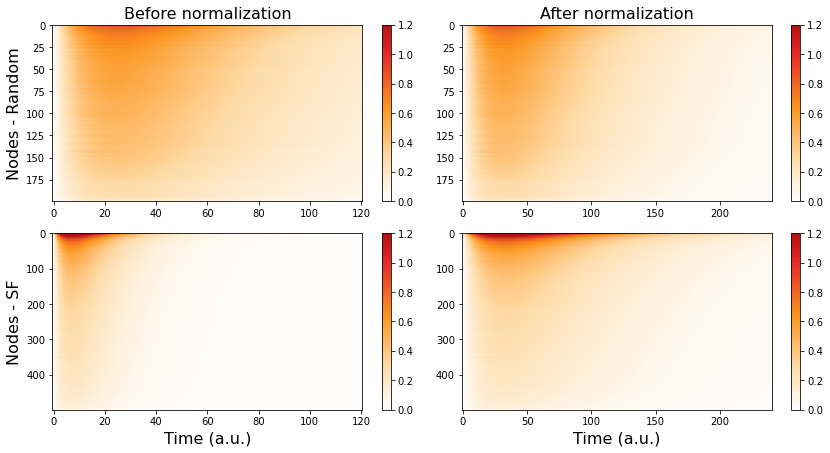

In [145]:
newidx1 = totnoderesp1.argsort()[::-1]
newidx3 = totnoderesp3.argsort()[::-1]

plt.figure(figsize=(12,6.4))
plt.subplot(2,2,1)
plt.title( 'Before normalization', fontsize=16 );
plt.imshow(noderesp1[:,newidx1].T, vmin=0, aspect='auto', cmap=seqhot)
plt.clim(0,1.2)
plt.colorbar()
#plt.xlabel( 'Time (a.u.)', fontsize=16)
plt.ylabel( 'Nodes - Random', fontsize=16 )

plt.subplot(2,2,3)
plt.imshow(noderesp3[:,newidx3].T, vmin=0, aspect='auto', cmap=seqhot)
plt.clim(0,1.2)
plt.colorbar()
plt.xlabel( 'Time (a.u.)', fontsize=16)
plt.ylabel( 'Nodes - SF', fontsize=16 )

plt.subplot(2,2,2)
plt.title( 'After normalization', fontsize=16 );
plt.imshow(nnoderesp1[:,newidx1].T, vmin=0, aspect='auto', cmap=seqhot)
plt.clim(0,1.2)
plt.colorbar()
#plt.xlabel( 'Time (a.u.)', fontsize=16)
#plt.ylabel( 'Nodes - Random', fontsize=16 )

plt.subplot(2,2,4)
plt.imshow(nnoderesp3[:,newidx3].T, vmin=0, aspect='auto', cmap=seqhot)
plt.clim(0,1.2)
plt.colorbar()
plt.xlabel( 'Time (a.u.)', fontsize=16)
#plt.ylabel( 'Nodes - SF', fontsize=16 )

plt.tight_layout()

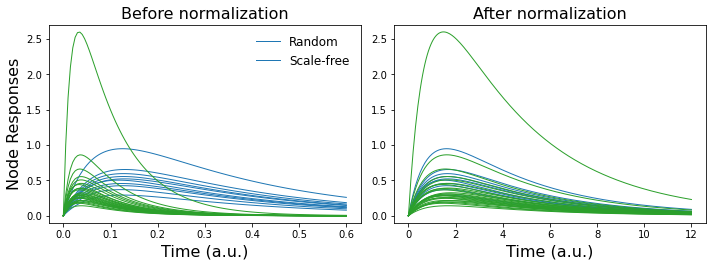

In [172]:
plt.figure(figsize=(10,3.8))
plt.subplot(1,2,1)
plt.title( 'Before normalization', fontsize=16 );
plt.plot(tpoints,noderesp1[:,newidx1[::20]], lw=1, color=cols[0]);
plt.plot(tpoints,noderesp3[:,newidx3[::20]], lw=1, color=cols[2]);
plt.ylim(-0.1,2.7)
plt.xlabel( 'Time (a.u.)', fontsize=16)
plt.ylabel( 'Node Responses', fontsize=16)
plt.legend(frameon=False, labels=('Random','Scale-free'), fontsize=12 )

plt.subplot(1,2,2)
plt.title( 'After normalization', fontsize=16 );
plt.plot(ntpoints,nnoderesp1[:,newidx1[::20]], lw=1, color=cols[0]);
plt.plot(ntpoints,nnoderesp3[:,newidx3[::20]], lw=1, color=cols[2]);
plt.ylim(-0.1,2.7)
plt.xlabel( 'Time (a.u.)', fontsize=16)

plt.tight_layout()


In [83]:
dij1 = galib.metrics_numba.FloydWarshall_Numba(net1)
dij2 = galib.metrics_numba.FloydWarshall_Numba(net2)
dij3 = galib.metrics_numba.FloydWarshall_Numba(net3)
avlen1 = (dij1.sum() - dij1.trace()) / (N1*(N1-1))
avlen2 = (dij2.sum() - dij2.trace()) / (N1*(N1-1))
avlen3 = (dij3.sum() - dij3.trace()) / (N2*(N2-1))


ttp1 = sna.Time2Peak(netresp1, dt)
ttp2 = sna.Time2Peak(netresp2, dt)
ttp3 = sna.Time2Peak(netresp3, dt)
avttp1 = (ttp1.sum() - ttp1.trace()) / (N1*(N1-1))
avttp2 = (ttp2.sum() - ttp2.trace()) / (N1*(N1-1))
avttp3 = (ttp3.sum() - ttp3.trace()) / (N2*(N2-1))

nttp1 = sna.Time2Peak(nnetresp1, dt)
nttp2 = sna.Time2Peak(nnetresp2, dt)
nttp3 = sna.Time2Peak(nnetresp3, dt)
navttp1 = (nttp1.sum() - nttp1.trace()) / (N1*(N1-1))
navttp2 = (nttp2.sum() - nttp2.trace()) / (N1*(N1-1))
navttp3 = (nttp3.sum() - nttp3.trace()) / (N2*(N2-1))



In [88]:
print( avlen1, avlen2, avlen3 )
print( avttp1, avttp2, avttp3 )
print( navttp1, navttp2, navttp3 )
print()
print( avlen1/avlen1, avlen2/avlen1, avlen3/avlen1 )
print( avttp1/avttp1, avttp2/avttp1, avttp3/avttp1 )
print( navttp1/navttp1, navttp2/navttp1, navttp3/navttp1 )

2.3971859296482414 5.477386934673367 2.085498997995992
0.2261233668341709 0.4179396984924623 0.05964729458917836
0.2916236180904523 0.8357788944723616 0.26639643286573156

1.0 2.284923696126111 0.8699779905274241
1.0 1.8482817779684009 0.26378209127286306
1.0 2.865950638514916 0.9134940256557132


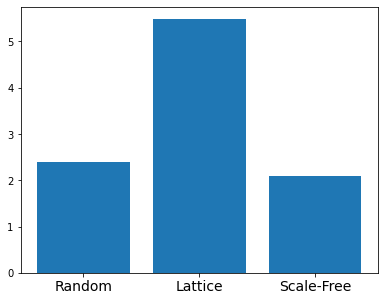

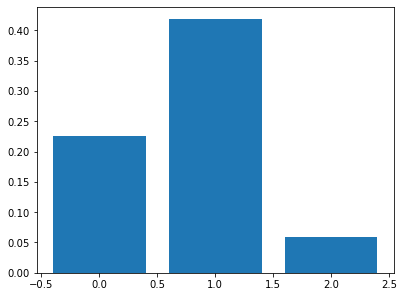

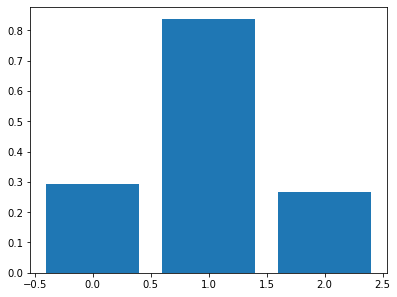

In [100]:
plt.figure()
plt.bar(arange(3),(avlen1, avlen2, avlen3) )
plt.xticks(arange(3),('Random','Lattice','Scale-Free'), fontsize=14);

plt.figure()
plt.bar(arange(3),(avttp1, avttp2, avttp3) );

plt.figure()
plt.bar(arange(3),(navttp1, navttp2, navttp3) );


In [93]:
print( corrcoef(dij3.flatten(),ttp3.flatten())[0,1] )
print( corrcoef(dij3.flatten(),nttp3.flatten())[0,1] )

0.8598812959365221
0.8651001489546225


In [ ]:
# Plot the (input) degree - node response relations
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.scatter(indeg1, totnoderesp1, c=cols[0], label='small - sparse')
plt.scatter(indeg2, totnoderesp2, c=cols[1], label='small - dense')
plt.scatter(indeg3, totnoderesp3, c=cols[2], label='large - sparse')
plt.scatter(indeg4, totnoderesp4, c=cols[3], label='large - dense')

plt.ylim(-0.01,0.52)
plt.tick_params( labelsize=14 )
plt.xlabel( 'Node (in-)Degree ', fontsize=16 )
plt.ylabel( 'Node (in-)Responses', fontsize=16 )

plt.legend( frameon=False, fontsize=12 )
plt.tight_layout()


Short description here.

<br>

## 2. Network properties after normalization

Brief explanation of normalization by λmax.

In [ ]:
# Compare the (input) degrees to the node responses
nnoderesp1 = sna.NodeResponses(nnetresp1)[0]
nnoderesp2 = sna.NodeResponses(nnetresp2)[0]
nnoderesp3 = sna.NodeResponses(nnetresp3)[0]
nnoderesp4 = sna.NodeResponses(nnetresp4)[0]

# Integrate the response of every node over time
ntotnoderesp1 = sna.AreaUnderCurve(nnoderesp1, dt)
ntotnoderesp2 = sna.AreaUnderCurve(nnoderesp2, dt)
ntotnoderesp3 = sna.AreaUnderCurve(nnoderesp3, dt)
ntotnoderesp4 = sna.AreaUnderCurve(nnoderesp4, dt)


In [ ]:
# Plot the (input) degree - node response relations
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

maxylim = max( ntotnoderesp1.max(),ntotnoderesp2.max(),ntotnoderesp3.max(),ntotnoderesp4.max() )

plt.scatter(indeg1, ntotnoderesp1, c=cols[0], label='small - sparse')
plt.scatter(indeg2, ntotnoderesp2, c=cols[1], label='small - dense')
plt.scatter(indeg3, ntotnoderesp3, c=cols[2], label='large - sparse')
plt.scatter(indeg4, ntotnoderesp4, c=cols[3], label='large - dense')

plt.ylim(-0.02*maxylim, 1.05*maxylim)
plt.tick_params( labelsize=14 )
plt.xlabel( 'Node (in-)Degree ', fontsize=16 )
plt.ylabel( 'Node (in-)Responses', fontsize=16 )

plt.legend( frameon=False, fontsize=12 )
plt.tight_layout()


<br>

## 3. Comparison across graph models

Use precomputed results for Random, Lattice and ScaleFree to plot:

- Figure-1: GlobalResp of the three models withouth normalization.
- Figure-2: GlobalResp of the three models, after evmax normalization.
- Maybe show the node-wise responses as "imshow" ?

In [ ]:
# Generate three graphs, of different class, size and density
net_ran = galib.models.RandomGraph(N1,L1s).astype(float64)
net_lat = galib.models.Lattice1D(N1,z1d).astype(float64)
net_sfr = galib.models.ScaleFreeGraph(N2,L2s)


In [ ]:
# Compute the eigenvalues of the three networks
evs_ran = numpy.linalg.eigvals(net_ran)
evs_lat = numpy.linalg.eigvals(net_lat)
evs_sfr = numpy.linalg.eigvals(net_sfr)

# Find the largest eigenvalues, and the corresponding critical τ for each network
evmax_ran = SpectralRadius(evs_ran); taumax_ran = 1.0 / evmax_ran
evmax_lat = SpectralRadius(evs_lat); taumax_lat = 1.0 / evmax_lat
evmax_sfr = SpectralRadius(evs_sfr); taumax_sfr = 1.0 / evmax_sfr

# Print some feedback: spectral radius and corresponding critical 'tau's
print( 'BEFORE NOREMALIZATION ...')
print( '\tSpectral radius\t\tLargest tau' )
print( 'net ran:   %3.5f\t\t%2.5f'  %(evmax_ran, taumax_ran) )
print( 'net lat:   %3.5f\t\t%2.5f'  %(evmax_lat, taumax_lat) )
print( 'net sfr:   %3.5f\t\t%2.5f'  %(evmax_sfr, taumax_sfr) )



# Normalize the three networks by their corresponding spectral radius
nnet_ran = net_ran / evmax_ran
nnet_lat = net_lat / evmax_lat
nnet_sfr = net_sfr / evmax_sfr

# Compute the eigenvalues of the normalised networks
nevs_ran = numpy.linalg.eigvals(nnet_ran)
nevs_lat = numpy.linalg.eigvals(nnet_lat)
nevs_sfr = numpy.linalg.eigvals(nnet_sfr)

# Find the largest eigenvalues, and the corresponding critical τ for each network
nevmax_ran = SpectralRadius(nevs_ran); ntaumax_ran = 1.0 / nevmax_ran
nevmax_lat = SpectralRadius(nevs_lat); ntaumax_lat = 1.0 / nevmax_lat
nevmax_sfr = SpectralRadius(nevs_sfr); ntaumax_sfr = 1.0 / nevmax_sfr

# Print some feedback: spectral radius and corresponding critical 'tau's
print( '\nAFTER NORMALIZATION ...')
print( '\tSpectral radius\t\tLargest tau' )
print( 'net ran:   %3.5f\t\t%2.5f'  %(nevmax_ran, ntaumax_ran) )
print( 'net lat:   %3.5f\t\t%2.5f'  %(nevmax_lat, ntaumax_lat) )
print( 'net sfr:   %3.5f\t\t%2.5f'  %(nevmax_sfr, ntaumax_sfr) )


In [ ]:
# Plot the eigenvalues of the normalized graphs
plt.figure()
ax1 = plt.subplotaxes()
ax.spines[['left','top','right']].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.scatter(nevs1.real, 0.01 + nevs1.imag, c=cols[0], label='small / sparse')
plt.scatter(nevs2.real, 0.02 + nevs2.imag, c=cols[1], label='small / dense')
plt.scatter(nevs3.real, 0.03 + nevs3.imag, c=cols[2], label='large / sparse')
plt.scatter(nevs4.real, 0.04 + nevs4.imag, c=cols[3], label='large / dense')

plt.scatter(nevmax1, 0.01, marker='x', s=100, lw=3, c=cols[0])
plt.scatter(nevmax2, 0.02, marker='x', s=100, lw=3, c=cols[1])
plt.scatter(nevmax3, 0.03, marker='x', s=100, lw=3, c=cols[2])
plt.scatter(nevmax4, 0.04, marker='x', s=100, lw=3, c=cols[3])

plt.ylim(0.005,0.045)
plt.tick_params( labelsize=16 )

#plt.legend(frameon=False, loc='lower right', fontsize=12)
plt.tight_layout()



In [ ]:
# COMPUTE THE DYNAMIC COMMUNICABILITY AND CALCULATE SOME PROPERTIES
# 1.1) Define the simulation parameters
# Define the temporal resolution
ntfinal = 12.0
ndt = 0.05
ntpoints = arange(0.0, ntfinal+0.1*ndt, ndt)
#nnsteps = len(ntpoints)

# Set the decay time-constants τ, proportional to taumax
# After normalization all taumax = 1.0, hence, we only need one value for
# all four networks.
ntau = 0.8

# Define the inputs to every node
stim = 1.0


In [ ]:
# Calculate the evolution of communicability over time for the nets
print('\nCalculating the dynamic communicability tensors from t=0 to t=%3.1f, with step=%3.3f ...' %(ntfinal, ndt) )
time1 = timer()
nnetresp1 = sna.Resp_LC(nnet1.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nnetresp2 = sna.Resp_LC(nnet2.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nnetresp3 = sna.Resp_LC(nnet3.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
nnetresp4 = sna.Resp_LC(nnet4.T, tau=ntau, S0=stim, tmax=ntfinal, timestep=ndt, case='regressed')
time2 = timer()
print( time2 - time1, 'seconds' )


In [ ]:
# 1.4) Compute the global network responses
# Sum of all pair-wise responses, at every time-point
nglobalresp1 = sna.GlobalResponse(nnetresp1)
nglobalresp2 = sna.GlobalResponse(nnetresp2)
nglobalresp3 = sna.GlobalResponse(nnetresp3)
nglobalresp4 = sna.GlobalResponse(nnetresp4)


In [ ]:
# Plot the global network responses
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

plt.plot(ntpoints, nglobalresp2, lw=3, c=cols[1],           label='small / dense')
plt.plot(ntpoints, nglobalresp1, lw=3, c=cols[0], ls='--',  label='small / sparse')
plt.plot(ntpoints, nglobalresp4, lw=3, c=cols[3],           label='large / dense')
plt.plot(ntpoints, nglobalresp3, lw=3, c=cols[2], ls='--',  label='large / sparse')

plt.ylim(-5,310)
plt.tick_params( labelsize=14 )
plt.xlabel('Time (a.u.)', fontsize=16)
plt.ylabel('Global Netw. Response, $r(t)$', fontsize=16)

plt.legend(frameon=False, fontsize=12)
plt.tight_layout()


In [ ]:
# Compare the (input) degrees to the node responses
nnoderesp1 = sna.NodeResponses(nnetresp1)[0]
nnoderesp2 = sna.NodeResponses(nnetresp2)[0]
nnoderesp3 = sna.NodeResponses(nnetresp3)[0]
nnoderesp4 = sna.NodeResponses(nnetresp4)[0]

# Integrate the response of every node over time
ntotnoderesp1 = sna.AreaUnderCurve(nnoderesp1, dt)
ntotnoderesp2 = sna.AreaUnderCurve(nnoderesp2, dt)
ntotnoderesp3 = sna.AreaUnderCurve(nnoderesp3, dt)
ntotnoderesp4 = sna.AreaUnderCurve(nnoderesp4, dt)


In [ ]:
# Plot the (input) degree - node response relations
plt.figure()
ax = plt.axes()
ax.spines[['top','right']].set_visible(False)

maxylim = max( ntotnoderesp1.max(),ntotnoderesp2.max(),ntotnoderesp3.max(),ntotnoderesp4.max() )

plt.scatter(indeg1, ntotnoderesp1, c=cols[0], label='small - sparse')
plt.scatter(indeg2, ntotnoderesp2, c=cols[1], label='small - dense')
plt.scatter(indeg3, ntotnoderesp3, c=cols[2], label='large - sparse')
plt.scatter(indeg4, ntotnoderesp4, c=cols[3], label='large - dense')

plt.ylim(-0.02*maxylim, 1.05*maxylim)
plt.tick_params( labelsize=14 )
plt.xlabel( 'Node (in-)Degree ', fontsize=16 )
plt.ylabel( 'Node (in-)Responses', fontsize=16 )

plt.legend( frameon=False, fontsize=12 )
plt.tight_layout()


In [ ]:
# Generate three graphs of different class and different size / density
net_ran = galib.models.RandomGraph(N1,L1s).astype(float64)
net_lat = galib.models.Lattice1D(N1,z1d).astype(float64)
net_sfr = galib.models.ScaleFreeGraph(N2,L2s).astype(float64)
